In [1]:
%load_ext autoreload
%autoreload 2

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as const
%matplotlib inline
import pickle,time
from scipy.constants import c
from LumericalLibraries.mode_solutions import mode_sol
from LumericalLibraries.overlap_calc import Overlap_calc
from itertools import product

from scipy.optimize import curve_fit
import L_eff

In [3]:
currents = [500,700,1000,1300,1600,1990,2200,2500]
namePrefix = 'SR_data_SWITCH1_2xUOC_30dBedfa_'
nameSufix = 'mA_comp66mA_wl_smallEdfa_52mA.csv'

max pos_ch4 500 mA = 33.75 ps
max pos_ch4 700 mA = 16.75 ps
max pos_ch4 1000 mA = 17.5 ps
max pos_ch4 1300 mA = 16.25 ps
max pos_ch4 1600 mA = 16.0 ps
max pos_ch4 1990 mA = 18.0 ps
max pos_ch4 2200 mA = 16.25 ps
max pos_ch4 2500 mA = 16.0 ps


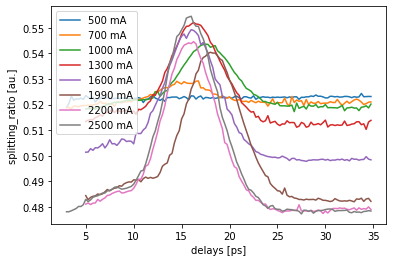

In [4]:
# load all CSV files and plot
for current in currents:
    name = namePrefix + str(current) + nameSufix 
    data = pd.read_csv (name)
    df = pd.DataFrame(data, columns= [ 'delays (ps)', 'powers1', 'powers2', 'pump_power', 'tap power', 'splitting_ratio'])
    # print (df)
    plt.plot(pd.DataFrame(data, columns= [ 'delays (ps)']),pd.DataFrame(data, columns= ['splitting_ratio']), label = str(current) + ' mA')
    [y,x]=[pd.DataFrame(data, columns= [ 'delays (ps)']),pd.DataFrame(data, columns= ['splitting_ratio'])]
    x = np.array(x.values.tolist()).reshape(len(x))
    y = np.array(y.values.tolist()).reshape(len(y))
    xMax = np.where(x == x.max())[0][0]
    print ('max pos' + '_ch4 ' + str(current) + ' mA = ' + str(y[xMax]) + ' ps' )
plt.ylabel('splitting_ratio [au.]')
plt.xlabel('delays [ps]')
plt.legend()
plt.show()

In [5]:
def dip_gauss_model(x, pos, fwhm, ceil, amplitude):
    """A simple exp^2 dip model.
    
    Args:
        * x (float): 'motor position' [mm]
        * pos (float): dip position [mm]
        * fwhm (float): dip fwhm [mm]
        * ceil (float): coincidence count away from the dip (the 'ceilin')
        * amplitude (float): dip amplitude.
            The coincidence count in the dip is `ceil - amplitude`.
    
    Returns:
        * float hom_coincs: number of HOM coincidences at a given `x`.
    
    Notes:
        * +`fwhm/tau` is approximately 2.355
    """
    width = fwhm / 2.355
    dip = ceil - amplitude * np.exp(-(x - pos)**2 / (2 * width**2))
    return dip

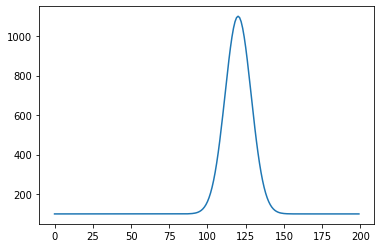

In [6]:
#test how the plotting fce. looks like
plt.plot([dip_gauss_model(x,20,20,100,-1000) for x in np.arange(-100,100,1)]) 

In [7]:
# find starting points for fit
def Getp0(scan): 
    ceil = ((pd.DataFrame(scan, columns= ['splitting_ratio']).values[0]+pd.DataFrame(scan, columns= ['splitting_ratio']).values[-1])/2)[0]
    maxim = pd.DataFrame(scan, columns= ['splitting_ratio']).max()[0]
    minim = pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0]
    if abs(ceil-minim) < abs(ceil-maxim):
        amplitude = ceil-maxim
        pos = data.loc[data['splitting_ratio'] == pd.DataFrame(data, columns= ['splitting_ratio']).max()[0], 'delays (ps)'].values
        fwhm = scan.loc[scan['splitting_ratio'] > 
         abs(pd.DataFrame(scan, columns= ['splitting_ratio']).max()[0]-pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0])/np.exp(1)+pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0]
         , 'delays (ps)'].values[-1] - scan.loc[data['splitting_ratio'] > 
         abs(pd.DataFrame(scan, columns= ['splitting_ratio']).max()[0]-pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0])/np.exp(1)+pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0]
         , 'delays (ps)'].values[0]
    else:
        amplitude = ceil-minim
        pos = data.loc[data['splitting_ratio'] == pd.DataFrame(data, columns= ['splitting_ratio']).min()[0], 'delays (ps)'].values
        fwhm = scan.loc[scan['splitting_ratio'] < 
         abs(pd.DataFrame(scan, columns= ['splitting_ratio']).max()[0]-pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0])/np.exp(1)+pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0]
         , 'delays (ps)'].values[-1] - scan.loc[data['splitting_ratio'] < 
         abs(pd.DataFrame(scan, columns= ['splitting_ratio']).max()[0]-pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0])/np.exp(1)+pd.DataFrame(scan, columns= ['splitting_ratio']).min()[0]
         , 'delays (ps)'].values[0]
    return([pos[0], fwhm, ceil, amplitude])

# convert dBm to mW
def dBm2mW(P_dBm):
    P_mW = 1 * 10**(P_dBm/ 10)
    return (P_mW)

In [8]:
def GetPhase(fit): #get phase in Pi from fit
    phase = fit[-1]
    return abs(2*phase)

In [9]:
def FitPlotData(data, n=0, prt=True, dBm=True):
    [x,y] = [pd.DataFrame(data, columns= [ 'delays (ps)']).values,pd.DataFrame(data, columns= ['splitting_ratio']).values]
    [x,y] = [x.reshape(len(x)),y.reshape(len(y))]
    try:
        fit = curve_fit(dip_gauss_model, x, y, Getp0(data))[0]
        plt.plot(x, dip_gauss_model(x, *fit), alpha=0.3, color=f"C{n}")
        if prt==True:
            print (fit)
            print (str(GetPhase(fit)) + ' pi')
    except:
        print ('noFit')
    on_chip = (pd.DataFrame(data, columns= ['tap power']).mean().values[0]+20 - pd.DataFrame(data, columns= ['pump_power']).mean().values[0])/2+pd.DataFrame(data, columns= ['pump_power']).mean().values[0]
    if dBm == True:
        plt.plot(pd.DataFrame(data, columns= [ 'delays (ps)']),pd.DataFrame(data, columns= ['splitting_ratio']), marker='o', markersize=1, linestyle = 'None', color=f"C{n}", label = str(on_chip.round(2)) + ' dBm')
        print(str(on_chip) + ' dBm')
    else:
        on_chip = dBm2mW(on_chip)
        plt.plot(pd.DataFrame(data, columns= [ 'delays (ps)']),pd.DataFrame(data, columns= ['splitting_ratio']), marker='o', markersize=1, linestyle = 'None', color=f"C{n}", label = str(on_chip.round(2)) + ' mW')
        print(str(on_chip) + ' mW')
    return([on_chip,GetPhase(fit)])
    #return([on_chip,GetPhase(data)])

[ 4.25993029e+01  3.07426712e+03 -2.01965742e+00 -2.54282715e+00]
5.0856542909907745 pi
0.06312099090309471 mW
Loss = 15.736556834524485 dBm
[ 1.53432421e+01  6.04330285e+00  5.20601912e-01 -8.15545479e-03]
0.016310909574871087 pi
3.139703481777084 mW
Loss = 15.45567200131762 dBm
[17.62198481  6.3597901   0.51948922 -0.02380888]
0.047617769940245 pi
9.313464731376373 mW
Loss = 15.187422648388978 dBm
[16.40856164  6.37521436  0.51343483 -0.03808868]
0.07617736032222146 pi
15.650352185632629 mW
Loss = 15.177436316099463 dBm
[15.94773081  6.68792371  0.49979607 -0.04832261]
0.09664521917958957 pi
22.139757041257663 mW
Loss = 15.17648646335612 dBm
[18.17124103  6.70320562  0.48435649 -0.05595692]
0.11191384901844942 pi
30.842412965343136 mW
Loss = 15.178809063971054 dBm
[15.86499255  6.5226925   0.47988056 -0.0640956 ]
0.1281911902576624 pi
34.22267955548781 mW
Loss = 15.407926306272895 dBm
[15.91591548  6.67408253  0.47994743 -0.07308425]
0.146168492431324 pi
39.391393037330865 mW
Loss = 

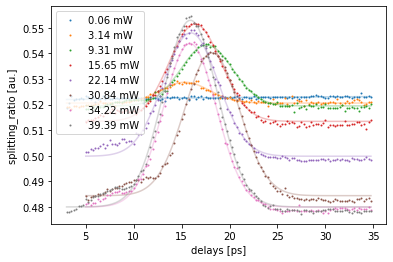

In [10]:
phaseList = []
for n,current in enumerate(currents):
    name = namePrefix + str(current) + nameSufix 
    data = pd.read_csv (name)
    phaseList.append(FitPlotData(data,n,dBm=False, prt=True))
    out_ = pd.DataFrame(data, columns= ['pump_power']).mean().values[0]
    in_ = pd.DataFrame(data, columns= ['tap power']).mean().values[0]+20
    loss_ = in_ - out_
    print ('Loss = ' + str(loss_) + ' dBm')
plt.ylabel('splitting_ratio [au.]')
plt.xlabel('delays [ps]')
plt.legend()
#plt.savefig('plot.pdf')
plt.show()

In [11]:
# losses in chip
out_ = pd.DataFrame(data, columns= ['pump_power']).mean().values[0]
in_ = pd.DataFrame(data, columns= ['tap power']).mean().values[0]+20
loss_ = in_ - out_
loss_

15.725960693694901

In [12]:
phaseList

[[0.06312099090309471, 5.0856542909907745],
 [3.139703481777084, 0.016310909574871087],
 [9.313464731376373, 0.047617769940245],
 [15.650352185632629, 0.07617736032222146],
 [22.139757041257663, 0.09664521917958957],
 [30.842412965343136, 0.11191384901844942],
 [34.22267955548781, 0.1281911902576624],
 [39.391393037330865, 0.146168492431324]]

In [13]:
phaseList[0][1] = 0 #fit error, based on the graph above, it should be approx. 0 && 0mW = Opi

In [14]:
phaseList

[[0.06312099090309471, 0],
 [3.139703481777084, 0.016310909574871087],
 [9.313464731376373, 0.047617769940245],
 [15.650352185632629, 0.07617736032222146],
 [22.139757041257663, 0.09664521917958957],
 [30.842412965343136, 0.11191384901844942],
 [34.22267955548781, 0.1281911902576624],
 [39.391393037330865, 0.146168492431324]]

In [15]:
realData = np.array(phaseList).T

# Lumerical simumation

# Define functions

In [18]:
def calc_peak_power(avg,rep,width):
    ''' Caclulates peak power from average power rep rate and pulse width '''
    pulse_energy = avg/rep

    return 0.94*(1-0.27)*pulse_energy/width #lobe correction

def calc_peak_power_uncorr(avg,rep,width):
    ''' Caclulates peak power from average power rep rate and pulse width '''
    pulse_energy = avg/rep

    return pulse_energy/width

def effective_length(pulse_width1,pulse_width2,beta1):

    ''' Caclulates the effective interaction length of 2 pulses with given pulse widths and group velocities '''

    # prefactor  = np.sqrt(2)/(0.441271*np.pi*2)
    prefactor  = (4*np.sqrt(np.log(2)))/(0.441271*np.pi*2)
    numerator = np.sqrt(pulse_width1**2 + pulse_width2**2)
    denomenator = abs(beta1[0] - beta1[1])

    return (prefactor * numerator)/denomenator

def phase_shift(L,ng_p,ng_s,overlap,power,wav):
    
    n2 = 2.4e-19 #nonlinear refractive index of silicon nitride
    n0 = 1.984675 #refractive index of silicon nitride
    
    prefactor = (4*np.pi*n2)/wav
    ns = ((ng_p * ng_s)/n0**2)

    return prefactor*ns* overlap * power * L

# Simulation parameters

Note that the general simulation parameters are also defined within the Overlap_calc class - definitely bad coding form so feel free to change that.

In [19]:
'''silicon nitride'''

simulation_params_nitride = {
'width': 2e-6,
'height':330e-9,
'top_cladding_thickness': 0.75e-6,
'bottom_cladding_thickness':3.3e-6,
'Mode_resolution':100,
'material_wg': "SiN (Silicon Nitride) - MuensterSpecs",
'material_clad': "HSQ - Munster spec"
}

start_wavelength = 1.550e-6
stop_wavelength = 1.560e-6
points = 2#5#20
step = (stop_wavelength-start_wavelength) / (points-1)


general_params = {
"wavelength" : (start_wavelength+stop_wavelength)/2, #1.5575e-6,
"start_wavelength":start_wavelength,
"stop_wavelength":stop_wavelength,
"N_points_Disp":points,
"d_wavelength" :step,
"Lc" : 1e-6,
"mesh_dx" : 0.1e-6,
"mesh_dy" : 0.1e-6,
"substrate_height": 2e-6,
"num_TE" : 4
} 


# Example sweeps just in MODE

Two example sweeps. First we will perform a sweep of the waveguide width but always at a fixed wavelength, and plot the effective indices of the transverse electric modes. Second we will perform a wavelength sweep for a fixed geometry and again plot the effective index of the transverse electric modes. The example plots have been performed with a large mesh so might not be too accurate.

In [21]:
simulation_params = dict()
simulation_params.update(simulation_params_nitride)
simulation_params.update(general_params)
MODE = mode_sol(simulation_params, hide = False, close = False, mode = 'TE') #open model_solutions.py and initialize lumerical

Initialising MODE instance...
Inputting simulation parameters...
Fitting material parameters...
Initialisation complete


In [22]:
width = 2.0*1e-6
L = 30 #length of waveguide in mm
f_rep = 500 #MHz

#Pulse 1 - sig.: TE0, 1555nm, 6.18ps
tau_p01 = 6.1827684 #pulse length in ps
P_avg01 = -27 #dBm
lamb_01 = 1555 #nm
n01 = 1.984675

#Pulse 2 - pump: TE1, 1560nm, 2.18ps
tau_p02 = 2.18215543 #pulse length in ps
P_avg02 = 10 #dBm
lamb_02 = 1560 #nm
n02 = 1.984675

Performing parameter sweep
Sweep complete
Performing frequency sweep
Sweep complete
Initialising MODE instance...
Inputting simulation parameters...
Fitting material parameters...
Initialisation complete
Getting mode info...


/home/martab/.local/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:234: ComplexWarning: Casting complex values to real discards the imaginary part
  nx, tx, ny, ty, c, fp, ier = dfitpack.regrid_smth(


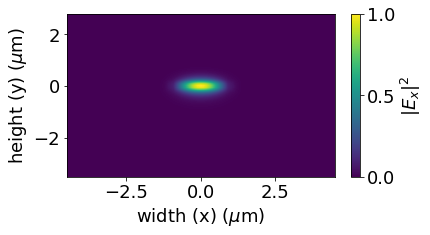

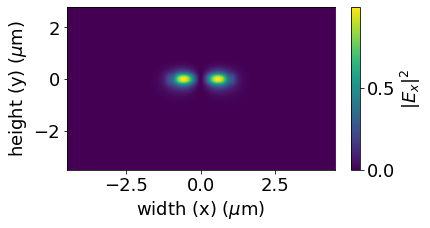

<Figure size 432x288 with 0 Axes>

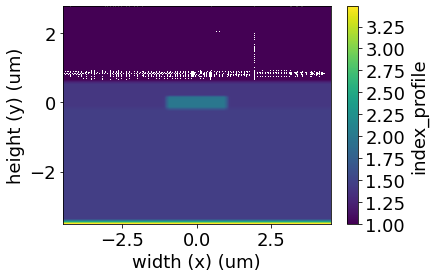

In [23]:
'''width sweep'''
param_sweep = {
    'parameter':'width',
    'parameter_start': width,
    'parameter_end': width,
    'steps': 1
}
neff_array = MODE.parameter_sweep(param_sweep) # create array of n_eff for diferent width of waveguide (defined in param_sweep) and supported TE
neff_plot_arrays = [[] for _ in range(MODE.simulation_parameters['num_TE'])]
neff_array,vg_array,D_array,wavs = MODE.freq_sweep() # go through  wavelenghts for single wavegide geometry
    
index1 = np.where(abs(wavs-lamb_01*1e-9) == min(abs(wavs-lamb_01*1e-9)))[0][0]
v_g01 = vg_array[0][index1]
lamb01 = wavs[index1]*10**9

index2 = np.where(abs(wavs-lamb_02*1e-9) == min(abs(wavs-lamb_02*1e-9)))[0][0]
v_g02 = vg_array[1][index2]
lamb02 = wavs[index2]*10**9

    
mode_indices = [0,1]
simulation_params['width']=width
OL = Overlap_calc(simulation_params,mode_indices)
nonlinear_overlap,TE0_overlap,TE1_overlap,lin_ols = OL.NL_overlap(freq_sweep = 1)
vg_array = OL.vgs
lumerical_res = [nonlinear_overlap,TE0_overlap,TE1_overlap,lin_ols,vg_array]
    
Aeff01 = (1/TE0_overlap)* 1e12
Aeff02 = (1/TE1_overlap)* 1e12
l_eff = L_eff.L_eff(L,f_rep,Aeff01,tau_p01,v_g01,lamb01,Aeff02,tau_p02,v_g02,lamb02,P_avg01,P_avg02,n01,n02)

In [24]:
'''laser parameters'''

rep_rate = f_rep*1e6 #500e6
#c = 3e8
lambda_signal = lamb01*1e-9 #1555e-9
lambda_pump = lamb02*1e-9 #1560e-9

signal_pulse_width = tau_p01*1e-12 #6.18e-12 #5e-12
pump_pulse_width = tau_p02*1e-12 #3.87e-12 #4e-12

average_power_array = np.linspace(0,60,10)*1e-3

'''Switch geometry'''

#width = 2e-6
acc_L = L*1e-3
acc_L_real = l_eff

In [25]:
def Get_phase(lumer,acc_L,average_power_array, corr=False):
    [nonlinear_overlap,TE0_overlap,TE1_overlap,lin_ols,vg_array] = lumer
    beta1_pump = 1/vg_array[1][index2]
    beta1_signal = 1/vg_array[0][index1]

    ngp = c/vg_array[1][index2]
    ngs = c/vg_array[0][index1]
    
    phase_shifts = []
    for avg_power in average_power_array:
        if corr == False:
            peak_power = calc_peak_power_uncorr(avg_power,rep_rate,pump_pulse_width)
        if corr == True:
            peak_power = calc_peak_power(avg_power,rep_rate,pump_pulse_width)
        PS = phase_shift(acc_L,ngp,ngs,nonlinear_overlap,peak_power,lambda_signal)/np.pi
        phase_shifts.append(PS)
    return (phase_shifts)

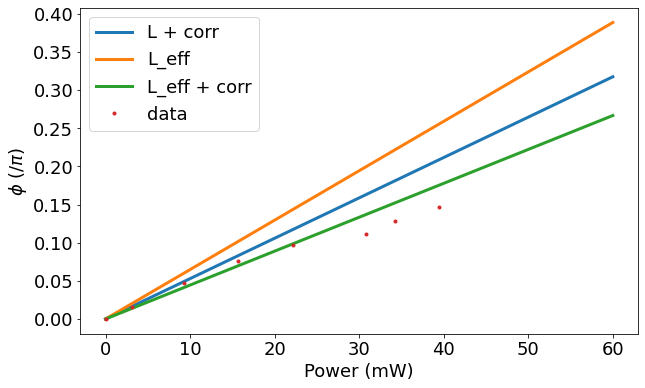

In [26]:
fig,ax = plt.subplots(figsize = (10,6))
ax.set_xlabel(r'Power (mW)')
ax.set_ylabel(r'$\phi$ (/$\pi$)')

phase_shifts = Get_phase(lumerical_res,acc_L_real,average_power_array,False)
phase_shifts_2 = Get_phase(lumerical_res,acc_L,average_power_array,True)
phase_shifts_3 = Get_phase(lumerical_res,acc_L_real,average_power_array,True)

ax.plot(average_power_array*1e3,phase_shifts_2,'-',lw = 3, label = 'L + corr')
ax.plot(average_power_array*1e3,phase_shifts,'-',lw = 3, label = 'L_eff')
ax.plot(average_power_array*1e3,phase_shifts_3,'-',lw = 3, label='L_eff + corr')
ax.plot(realData[0],realData[1],'.',label = 'data')
ax.legend()
plt.savefig('2xUOC_500MHz.pdf')